# DEPENDENCIES

In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import (
    adfuller,
    arma_order_select_ic,
    grangercausalitytests,
)
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.vector_ar.vecm import (
    coint_johansen,
    select_order,
    select_coint_rank,
)
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.vector_ar.vecm import VECM

In [5]:
def plot_acf(df, col):
    fig, axes = plt.subplots(2, 2, figsize=(24, 12))
    ax1, ax2, ax3, ax4 = axes.flatten()

    sm.graphics.tsa.plot_acf(df[col].values.squeeze(), lags=20, ax=ax1)
    ax1.set_title(f"{col}: ACF of Original Data")

    sm.graphics.tsa.plot_acf(df[col].diff().dropna().values.squeeze(), lags=20, ax=ax2)
    ax2.set_title(f"{col}: ACF of Differenced Data")

    sm.graphics.tsa.plot_pacf(df[col].values.squeeze(), lags=20, ax=ax3)
    ax3.set_title(f"{col}: PACF of Original Data")
    sm.graphics.tsa.plot_pacf(df[col].diff().dropna().values.squeeze(), lags=20, ax=ax4)
    ax4.set_title(f"{col}: PACF of Differenced Data")

    plt.tight_layout()

    plt.show()

In [6]:
def coin_test(df, prod1, prod2):
    d1 = df[df["product"] == prod1].reset_index(drop=True)
    d2 = df[df["product"] == prod2].reset_index(drop=True)

    df = pd.merge(
        d1[["mid_price"]],
        d2[["mid_price"]],
        how="left",
        left_index=True,
        right_index=True,
        suffixes=(f"_{prod1}", f"_{prod2}"),
    )
    vecm_order = select_order(df, maxlags=10)
    print(vecm_order.summary())

    model = coint_johansen(endog=df, det_order=1, k_ar_diff=1)
    print("Eigen statistic:")
    print(model.eig)
    print("Critical values:")
    d = pd.DataFrame(model.cvt)
    d.rename(columns={0: "90%", 1: "95%", 2: "99%"}, inplace=True)
    print(d)
    print()
    print("Trace statistic:")
    print(pd.DataFrame(model.lr1))

    rank1 = select_coint_rank(df, det_order=1, k_ar_diff=1, method="trace", signif=0.01)
    print(rank1.summary())

    # Perform Granger causality tests
    max_lags = 5
    gc_results = grangercausalitytests(df, max_lags, verbose=True)

    vecm = VECM(
        df, k_ar_diff=1, coint_rank=1, deterministic="n"
    )  # Including a linear trend
    vecm_fit = vecm.fit()

    print(vecm_fit.summary())

    return vecm_fit

# READ DATA

In [7]:
dates = {
    # 1: [-2, -1, 0],
    # 2: [-1, 0, 1],
    3: [0, 1, 2]
}

df = []
for round, days in dates.items():
    for day in days:
        data = pd.read_csv(
            f"C:/Users/edmun/OneDrive/Desktop/2025-IMC-Global-Trading-Challenge/prosperity3bt/resources/round{round}/prices_round_{round}_day_{day}.csv",
            sep=";",
        )
        data["round"] = round

        df.append(data)

data = pd.concat(df)

In [8]:
data.sort_values(by=["round", "day", "timestamp"], ascending=[True, True, True])

day  timestamp                      product  bid_price_1  \
0         0          0  VOLCANIC_ROCK_VOUCHER_10500         99.0   
1         0          0                      DJEMBES      13493.0   
2         0          0                   CROISSANTS       4321.0   
3         0          0                         JAMS       6631.0   
4         0          0  VOLCANIC_ROCK_VOUCHER_10000        505.0   
...     ...        ...                          ...          ...   
139995    2     999900               PICNIC_BASKET2      30073.0   
139996    2     999900   VOLCANIC_ROCK_VOUCHER_9750        417.0   
139997    2     999900               PICNIC_BASKET1      58422.0   
139998    2     999900                   CROISSANTS       4241.0   
139999    2     999900   VOLCANIC_ROCK_VOUCHER_9500        666.0   

        bid_volume_1  bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  \
0               19.0          NaN           NaN          NaN           NaN   
1               72.0          NaN           NaN          NaN           NaN   
2              111.0          NaN           NaN          NaN           NaN   
3              210.0          NaN           NaN          NaN           NaN   
4               19.0          NaN           NaN          NaN           NaN   
...              ...          ...           ...          ...           ...   
139995           1.0      30072.0          39.0          NaN           NaN   
139996          20.0          NaN           NaN          NaN           NaN   
139997           1.0      58421.0          39.0          NaN           NaN   
139998         143.0          NaN           NaN          NaN           NaN   
139999          20.0          NaN           NaN          NaN           NaN   

        ask_price_1  ask_volume_1  ask_price_2  ask_volume_2  ask_price_3  \
0               100            19          NaN           NaN          NaN   
1             13494            72          NaN           NaN          NaN   
2              4322           111          NaN           NaN          NaN   
3              6633           210          NaN           NaN          NaN   
4               506            19          NaN           NaN          NaN   
...             ...           ...          ...           ...          ...   
139995        30078            20      30079.0          20.0          NaN   
139996          418            20          NaN           NaN          NaN   
139997        58432            20      58433.0          20.0          NaN   
139998         4242           143          NaN           NaN          NaN   
139999          667            20          NaN           NaN          NaN   

        ask_volume_3  mid_price  profit_and_loss  round  
0                NaN       99.5              0.0      3  
1                NaN    13493.5              0.0      3  
2                NaN     4321.5              0.0      3  
3                NaN     6632.0              0.0      3  
4                NaN      505.5              0.0      3  
...              ...        ...              ...    ...  
139995           NaN    30075.5              0.0      3  
139996           NaN      417.5              0.0      3  
139997           NaN    58427.0              0.0      3  
139998           NaN     4241.5              0.0      3  
139999           NaN      666.5              0.0      3  

[420000 rows x 18 columns]

In [9]:
#################################### VOLUME METRICS ####################################

# Most Bid Volume - Identifies which bid price has the highest volume.
data["most_bid_volume_idx"] = data[
    ["bid_volume_1", "bid_volume_2", "bid_volume_3"]
].idxmax(axis=1)

# Most Ask Volume - Identifies which ask price has the highest volume.
data["most_ask_volume_idx"] = data[
    ["ask_volume_1", "ask_volume_2", "ask_volume_3"]
].idxmax(axis=1)

# Highest Bid Volume - The highest bid volume across the three bid price levels.
data["most_bid_volume"] = data[["bid_volume_1", "bid_volume_2", "bid_volume_3"]].max(
    axis=1
)

# Highest Ask Volume - The highest ask volume across the three ask price levels.
data["most_ask_volume"] = data[["ask_volume_1", "ask_volume_2", "ask_volume_3"]].max(
    axis=1
)

data["total_bid_volume"] = data[["bid_volume_1", "bid_volume_2", "bid_volume_3"]].sum(
    axis=1
)

data["total_ask_volume"] = data[["ask_volume_1", "ask_volume_2", "ask_volume_3"]].sum(
    axis=1
)

data["volume_ratio"] = data["total_bid_volume"] / data["total_ask_volume"]

data["orderbook_imb"] = (
    (data["total_bid_volume"] - data["total_ask_volume"])
    / (data["total_bid_volume"] + data["total_ask_volume"])
    * 100
)

data["price_impact_sell"] = data["total_bid_volume"] / (
    data["ask_price_1"] - data["bid_price_1"]
)

data["price_impact_buy"] = data["total_ask_volume"] / (
    data["ask_price_1"] - data["bid_price_1"]
)

data["rate_of_bid"] = data.groupby("product")["total_bid_volume"].diff()

data["rate_of_ask"] = data.groupby("product")["total_ask_volume"].diff()


#################################### PRICE METRICS ####################################
# Most Bid Price - Determines the bid price corresponding to the highest bid volume.
data["most_bid"] = np.where(
    data["most_bid_volume_idx"] == "bid_volume_1",
    data["bid_price_1"],
    np.where(
        data["most_bid_volume_idx"] == "bid_volume_2",
        data["bid_price_2"],
        np.where(
            data["most_bid_volume_idx"] == "bid_volume_3", data["bid_price_3"], np.nan
        ),
    ),
)

# Most Ask Price - Determines the ask price corresponding to the highest ask volume.
data["most_ask"] = np.where(
    data["most_ask_volume_idx"] == "ask_volume_1",
    data["ask_price_1"],
    np.where(
        data["most_ask_volume_idx"] == "ask_volume_2",
        data["ask_price_2"],
        np.where(
            data["most_ask_volume_idx"] == "ask_volume_3", data["ask_price_3"], np.nan
        ),
    ),
)

#################################### MID PRICE METRICS ####################################
# Most Mid Price - The mid price of the highest bid and ask prices.
data["most_mid"] = (data["most_ask"] + data["most_bid"]) / 2


#################################### VWAP METRICS ####################################
# Most Micro Price - A weighted average price using both bid and ask volumes.
data["most_micro"] = (
    data["most_ask"] * data["most_bid_volume"]
    + data["most_bid"] * data["most_ask_volume"]
) / (data["most_ask_volume"] + data["most_bid_volume"])

# Micro Price - A weighted average price based on the first bid and ask levels.
data["micro_price"] = (
    data["ask_price_1"] * data["bid_volume_1"]
    + data["bid_price_1"] * data["ask_volume_1"]
) / (data["ask_volume_1"] + data["bid_volume_1"])

# Ask VWAP - The volume-weighted average price for the ask side using the top 3 ask levels.
data["ask_vwap"] = (
    data["ask_price_1"] * data["ask_volume_1"]
    + data["ask_price_2"] * data["ask_volume_2"]
    + data["ask_price_3"] * data["ask_volume_3"]
) / (data["ask_volume_1"] + data["ask_volume_2"] + data["ask_volume_3"])

# Bid VWAP - The volume-weighted average price for the bid side using the top 3 bid levels.
data["bid_vwap"] = (
    data["bid_price_1"] * data["bid_volume_1"]
    + data["bid_price_2"] * data["bid_volume_2"]
    + data["bid_price_3"] * data["bid_volume_3"]
) / (data["bid_volume_1"] + data["bid_volume_2"] + data["bid_volume_3"])

# VWAP Mid - The VWAP midpoint between the ask and bid sides.
data["vwap_mid"] = (data["ask_vwap"] + data["bid_vwap"]) / 2


C:\Users\edmun\AppData\Local\Temp\ipykernel_11804\1818607690.py:6: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  ].idxmax(axis=1)


In [10]:
data.columns

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss', 'round',
       'most_bid_volume_idx', 'most_ask_volume_idx', 'most_bid_volume',
       'most_ask_volume', 'total_bid_volume', 'total_ask_volume',
       'volume_ratio', 'orderbook_imb', 'price_impact_sell',
       'price_impact_buy', 'rate_of_bid', 'rate_of_ask', 'most_bid',
       'most_ask', 'most_mid', 'most_micro', 'micro_price', 'ask_vwap',
       'bid_vwap', 'vwap_mid'],
      dtype='object')

In [11]:
prices = [
    "mid_price",
    "most_mid",
    "most_micro",
    "micro_price",
    "vwap_mid",
]

# Resin

In [12]:
resin = data[data["product"] == "RAINFOREST_RESIN"].fillna(0)

In [13]:
resin["bid_price_1"].value_counts().sort_index()

bid_price_1
9992.0     25052
9997.0      1946
10000.0      444
10001.0     1409
10002.0      876
10003.0      273
Name: count, dtype: int64

In [14]:
resin["ask_price_1"].value_counts().sort_index()

ask_price_1
9997       265
9998       826
9999      1348
10000      427
10003     1875
10008    25259
Name: count, dtype: int64

max sell @ bid = 9999 because min ask is 9998, sell at bid buy at ask

max buy @ ask = 10_001 because max bid = 10_002, buy at ask sell at bid

## KELP

In [15]:
kelp = data[data["product"] == "KELP"].fillna(0)

In [16]:
kelp

day  timestamp product  bid_price_1  bid_volume_1  bid_price_2  \
5         0          0    KELP       2028.0          30.0          0.0   
17        0        100    KELP       2030.0           4.0       2028.0   
41        0        200    KELP       2029.0           1.0       2028.0   
46        0        300    KELP       2029.0          25.0          0.0   
66        0        400    KELP       2029.0           2.0       2028.0   
...     ...        ...     ...          ...           ...          ...   
139940    2     999500    KELP       2040.0          28.0          0.0   
139948    2     999600    KELP       2040.0          30.0          0.0   
139960    2     999700    KELP       2040.0          28.0          0.0   
139978    2     999800    KELP       2040.0          29.0          0.0   
139993    2     999900    KELP       2040.0          25.0          0.0   

        bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...  \
5                0.0          0.0           0.0         2032  ...   
17              31.0          0.0           0.0         2032  ...   
41              21.0          0.0           0.0         2032  ...   
46               0.0          0.0           0.0         2032  ...   
66              23.0          0.0           0.0         2030  ...   
...              ...          ...           ...          ...  ...   
139940           0.0          0.0           0.0         2042  ...   
139948           0.0          0.0           0.0         2042  ...   
139960           0.0          0.0           0.0         2043  ...   
139978           0.0          0.0           0.0         2043  ...   
139993           0.0          0.0           0.0         2041  ...   

        rate_of_bid  rate_of_ask  most_bid  most_ask  most_mid   most_micro  \
5               0.0          0.0    2028.0    2032.0    2030.0  2030.000000   
17              5.0          1.0    2028.0    2032.0    2030.0  2030.000000   
41            -13.0         -9.0    2028.0    2032.0    2030.0  2029.953488   
46              3.0          3.0    2029.0    2032.0    2030.5  2030.500000   
66              0.0          6.0    2028.0    2032.0    2030.0  2029.916667   
...             ...          ...       ...       ...       ...          ...   
139940          5.0         12.0    2040.0    2044.0    2042.0  2042.000000   
139948          2.0          0.0    2040.0    2044.0    2042.0  2042.000000   
139960         -2.0         -7.0    2040.0    2043.0    2041.5  2041.500000   
139978          1.0          1.0    2040.0    2043.0    2041.5  2041.500000   
139993         -4.0          1.0    2040.0    2043.0    2041.5  2041.500000   

        micro_price  ask_vwap bid_vwap vwap_mid  
5       2030.000000       0.0      0.0      0.0  
17      2030.228571       0.0      0.0      0.0  
41      2029.130435       0.0      0.0      0.0  
46      2030.500000       0.0      0.0      0.0  
66      2029.250000       0.0      0.0      0.0  
...             ...       ...      ...      ...  
139940  2041.600000       0.0      0.0      0.0  
139948  2041.714286       0.0      0.0      0.0  
139960  2041.500000       0.0      0.0      0.0  
139978  2041.500000       0.0      0.0      0.0  
139993  2040.833333       0.0      0.0      0.0  

[30000 rows x 38 columns]

In [17]:
sq = data[data["product"] == "SQUID_INK"].reset_index(drop=True)
kelp = data[data["product"] == "KELP"].reset_index(drop=True)

mid_coin = pd.merge(
    sq[["mid_price"]],
    kelp[["mid_price"]],
    how="left",
    left_index=True,
    right_index=True,
    suffixes=("_sq", "_kelp"),
)

In [18]:
coin_test(data, "SQUID_INK", "KELP")

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       0.6500      0.6517       1.916      0.6506
1       0.3893      0.3921       1.476      0.3902
2       0.2984      0.3022       1.348      0.2996
3       0.2525      0.2575       1.287      0.2541
4       0.2324      0.2385       1.262      0.2344
5       0.2190      0.2262       1.245      0.2213
6       0.2106      0.2189       1.234      0.2133
7       0.2074      0.2168       1.230      0.2104
8       0.2029      0.2134       1.225      0.2063
9       0.2017     0.2134*       1.224      0.2055
10     0.2006*      0.2134      1.222*     0.2047*
--------------------------------------------------
Eigen statistic:
[0.00177097 0.00083325]
Critical values:
       90%      95%      99%
0  16.1619  18.3985  23.1485
1   2.7055   3.8415   6.6349

Trace statistic:
           0
0  78.178923
1  25.006312
Johansen cointegration test using

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_SQUID_INK
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
L1.mid_price_SQUID_INK     0.0054      0.006      0.897      0.370      -0.006       0.017
L1.mid_price_KELP         -0.3424      0.014    -23.735      0.000      -0.371      -0.314
Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_KELP
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
L1.mid_price_SQUID_INK     0.0060      0.002      2.693      0.007       0.002       0.010
L1.mid_price_KELP         -0.4851      0.005    -91.275      0.000      -0.496      -0.475
        Loading coefficients (alpha) for equation mid_price_SQUID_INK         


In [19]:
vecm = VECM(
    mid_coin, k_ar_diff=1, coint_rank=1, deterministic="n"
)  # Including a linear trend
vecm_fit = vecm.fit()

print(vecm_fit.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_sq
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.mid_price_sq       0.0054      0.006      0.897      0.370      -0.006       0.017
L1.mid_price_kelp    -0.3424      0.014    -23.735      0.000      -0.371      -0.314
Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_kelp
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.mid_price_sq       0.0060      0.002      2.693      0.007       0.002       0.010
L1.mid_price_kelp    -0.4851      0.005    -91.275      0.000      -0.496      -0.475
            Loading coefficients (alpha) for equation mid_price_sq            
                 coef    std err          z    

In [20]:
out = durbin_watson(vecm_fit.resid)
for col, val in zip(mid_coin.columns, out):
    print(col, val)

mid_price_sq 2.0213565328526246
mid_price_kelp 2.2817133947000565


# SQUID INK

In [21]:
squid_ink = data[data["product"] == "SQUID_INK"]

In [22]:
squid_ink[squid_ink["day"] == 0]

day  timestamp    product  bid_price_1  bid_volume_1  bid_price_2  \
12        0          0  SQUID_INK       1968.0          30.0          NaN   
14        0        100  SQUID_INK       1969.0           4.0       1967.0   
35        0        200  SQUID_INK       1966.0           1.0       1965.0   
42        0        300  SQUID_INK       1965.0          25.0          NaN   
59        0        400  SQUID_INK       1966.0          25.0          NaN   
...     ...        ...        ...          ...           ...          ...   
139931    0     999500  SQUID_INK       1830.0          28.0          NaN   
139947    0     999600  SQUID_INK       1832.0           7.0       1831.0   
139970    0     999700  SQUID_INK       1834.0           1.0       1832.0   
139972    0     999800  SQUID_INK       1837.0          27.0          NaN   
139993    0     999900  SQUID_INK       1838.0          23.0          NaN   

        bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...  \
12               NaN          NaN           NaN         1971  ...   
14              31.0          NaN           NaN         1971  ...   
35              21.0          NaN           NaN         1969  ...   
42               NaN          NaN           NaN         1968  ...   
59               NaN          NaN           NaN         1968  ...   
...              ...          ...           ...          ...  ...   
139931           NaN          NaN           NaN         1833  ...   
139947          29.0          NaN           NaN         1834  ...   
139970          26.0          NaN           NaN         1835  ...   
139972           NaN          NaN           NaN         1839  ...   
139993           NaN          NaN           NaN         1841  ...   

        rate_of_bid  rate_of_ask  most_bid  most_ask  most_mid   most_micro  \
12              NaN          NaN    1968.0    1971.0    1969.5  1969.500000   
14              5.0          1.0    1967.0    1971.0    1969.0  1969.000000   
35            -13.0         -9.0    1965.0    1969.0    1967.0  1966.953488   
42              3.0          3.0    1965.0    1968.0    1966.5  1966.500000   
59              0.0          6.0    1966.0    1969.0    1967.5  1967.500000   
...             ...          ...       ...       ...       ...          ...   
139931          2.0          2.0    1830.0    1833.0    1831.5  1831.500000   
139947          8.0          1.0    1831.0    1835.0    1833.0  1833.071429   
139970         -9.0         -3.0    1832.0    1835.0    1833.5  1833.500000   
139972          0.0          2.0    1837.0    1840.0    1838.5  1838.500000   
139993         -4.0         -5.0    1838.0    1841.0    1839.5  1839.500000   

        micro_price  ask_vwap bid_vwap vwap_mid  
12      1969.500000       NaN      NaN      NaN  
14      1969.228571       NaN      NaN      NaN  
35      1966.130435       NaN      NaN      NaN  
42      1966.500000       NaN      NaN      NaN  
59      1967.612903       NaN      NaN      NaN  
...             ...       ...      ...      ...  
139931  1831.500000       NaN      NaN      NaN  
139947  1833.555556       NaN      NaN      NaN  
139970  1834.037037       NaN      NaN      NaN  
139972  1838.928571       NaN      NaN      NaN  
139993  1839.500000       NaN      NaN      NaN  

[10000 rows x 38 columns]

In [23]:
sq = data[data["product"] == "SQUID_INK"].reset_index(drop=True)
kelp = data[data["product"] == "KELP"].reset_index(drop=True)

mid_coin = pd.merge(
    sq[["mid_price"]],
    kelp[["mid_price"]],
    how="left",
    left_index=True,
    right_index=True,
    suffixes=("_sq", "_kelp"),
)

In [24]:
vecm_order = select_order(mid_coin, maxlags=10)
vecm_order.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [25]:
model = coint_johansen(endog=mid_coin, det_order=1, k_ar_diff=1)
print("Eigen statistic:")
print(model.eig)
print("Critical values:")
d = pd.DataFrame(model.cvt)
d.rename(columns={0: "90%", 1: "95%", 2: "99%"}, inplace=True)
print(d)
print()
print("Trace statistic:")
print(pd.DataFrame(model.lr1))


Eigen statistic:
[0.00177097 0.00083325]
Critical values:
       90%      95%      99%
0  16.1619  18.3985  23.1485
1   2.7055   3.8415   6.6349

Trace statistic:
           0
0  78.178923
1  25.006312


In [26]:
rank1 = select_coint_rank(
    mid_coin, det_order=1, k_ar_diff=1, method="trace", signif=0.01
)
print(rank1.summary())


Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          78.18          23.15
  1   2          25.01          6.635
-------------------------------------


In [27]:
# Perform Granger causality tests
max_lags = 5
gc_results = grangercausalitytests(mid_coin, max_lags, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.4851 , p=0.0000  , df_denom=29996, df_num=1
ssr based chi2 test:   chi2=25.4877 , p=0.0000  , df=1
likelihood ratio test: chi2=25.4768 , p=0.0000  , df=1
parameter F test:         F=25.4851 , p=0.0000  , df_denom=29996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=288.1345, p=0.0000  , df_denom=29993, df_num=2
ssr based chi2 test:   chi2=576.3651, p=0.0000  , df=2
likelihood ratio test: chi2=570.8981, p=0.0000  , df=2
parameter F test:         F=288.1345, p=0.0000  , df_denom=29993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=269.2266, p=0.0000  , df_denom=29990, df_num=3
ssr based chi2 test:   chi2=807.8682, p=0.0000  , df=3
likelihood ratio test: chi2=797.1811, p=0.0000  , df=3
parameter F test:         F=269.2266, p=0.0000  , df_denom=29990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=226.9936

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [28]:
vecm = VECM(
    mid_coin, k_ar_diff=1, coint_rank=1, deterministic="n"
)  # Including a linear trend
vecm_fit = vecm.fit()

print(vecm_fit.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_sq
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.mid_price_sq       0.0054      0.006      0.897      0.370      -0.006       0.017
L1.mid_price_kelp    -0.3424      0.014    -23.735      0.000      -0.371      -0.314
Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_kelp
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.mid_price_sq       0.0060      0.002      2.693      0.007       0.002       0.010
L1.mid_price_kelp    -0.4851      0.005    -91.275      0.000      -0.496      -0.475
            Loading coefficients (alpha) for equation mid_price_sq            
                 coef    std err          z    

In [29]:
out = durbin_watson(vecm_fit.resid)
for col, val in zip(mid_coin.columns, out):
    print(col, ":", val)

mid_price_sq : 2.0213565328526246
mid_price_kelp : 2.2817133947000565


In [30]:
(
    vecm_fit.lin_trend_coint
    + vecm_fit.alpha @ (vecm_fit.beta.T @ mid_coin.iloc[-1].values)
    + vecm_fit.gamma @ (mid_coin.iloc[-1].values - vecm_fit.fittedvalues[-1])
)

array([[0.35562284, 0.46790441]])

In [31]:
(
    mid_coin.iloc[-1].values
    + vecm_fit.alpha
    @ (vecm_fit.beta.T @ mid_coin.iloc[-2].values + vecm_fit.lin_trend_coint[0])
    + vecm_fit.gamma @ (mid_coin.iloc[-1].values - vecm_fit.fittedvalues[-1])
)

array([1820.85494843, 2040.96794336])

In [32]:
print(vecm_fit.alpha)
print()
print(vecm_fit.beta)
print()
print(vecm_fit.gamma)

[[-6.20579905e-04]
 [ 3.58373569e-05]]

[[ 1.        ]
 [-0.91325515]]

[[ 0.00538188 -0.34236735]
 [ 0.00595464 -0.48509457]]


In [33]:
vecm_fit.predict(steps=1)

array([[1820.85828675, 2040.97164439]])

# PICNIC BASKET 1 

In [34]:
cross = data[data["product"] == "CROISSANTS"]["mid_price"].reset_index(drop=True)
jams = data[data["product"] == "JAMS"]["mid_price"].reset_index(drop=True)
dj = data[data["product"] == "DJEMBES"]["mid_price"].reset_index(drop=True)

picnic1 = data[data["product"] == "PICNIC_BASKET1"].reset_index(drop=True)
picnic1["basket1"] = cross * 6 + jams * 3 + dj
picnic1.rename(columns={"mid_price": "mid_price1"}, inplace=True)
picnic1["prem_disc"] = picnic1["mid_price1"] - picnic1["basket1"]

picnic2 = data[data["product"] == "PICNIC_BASKET2"].reset_index(drop=True)
picnic2["basket2"] = cross * 4 + jams * 2
picnic2.rename(columns={"mid_price": "mid_price2"}, inplace=True)
picnic2["prem_disc"] = picnic2["mid_price2"] - picnic2["basket2"]

In [35]:
(picnic1["ask_price_1"] - picnic1["bid_price_1"]).value_counts()

9.0     13727
11.0     8523
10.0     4221
5.0      1432
4.0       917
6.0       544
1.0       459
12.0      137
2.0        39
7.0         1
Name: count, dtype: int64

In [36]:
(picnic2["ask_price_1"] - picnic2["bid_price_1"]).value_counts()

5.0    13579
6.0    11946
3.0     1441
7.0     1136
2.0     1119
1.0      424
4.0      355
Name: count, dtype: int64

In [37]:
picnic_mids = pd.merge(
    picnic1[["mid_price1", "basket1"]],
    picnic2[["mid_price2", "basket2"]],
    how="inner",
    left_index=True,
    right_index=True,
)

In [38]:
px.line(picnic1["prem_disc"])

In [39]:
px.line(picnic2["prem_disc"])

In [40]:
px.histogram(np.diff(picnic1["prem_disc"]))

In [41]:
def hurst(ts):
    lags = range(2, 100)

    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    return poly[0] * 2.0

<Axes: >

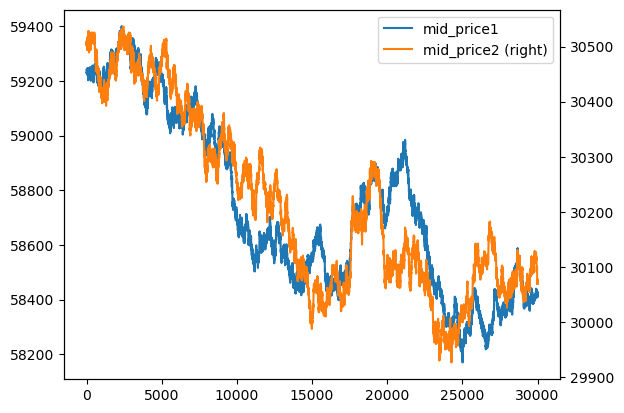

In [42]:
picnic_mids[["mid_price1", "mid_price2"]].plot(secondary_y="mid_price2")


In [43]:
forecast = np.zeros(len(picnic_mids))
x = picnic_mids[["mid_price1", "mid_price2"]].values
params = {
    "alpha": np.array([[-0.00019455], [0.00026457]]),
    "beta": np.array([[1.0, -1.94279816]]),
    "gamma": np.array(
        [[-0.03700845, -0.01196759], [-0.01018269, -0.0202882]],
    ),
}
p1 = np.zeros(len(picnic_mids))
p2 = np.zeros(len(picnic_mids))

for i in range(1, len(picnic_mids)):
    f1, f2 = params["alpha"] @ (params["beta"] @ x[i]) + params["gamma"] @ (
        x[i] - np.array(p1[i - 1], p2[i - 1])
    )
    p1[i] = f1 + x[i][0]
    p2[i] = f2 + x[i][1]


In [44]:
picnic_coin_vecm = coin_test(data, "PICNIC_BASKET1", "PICNIC_BASKET2")

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.566       4.568       96.20       4.567
1        4.565      4.567*       96.02      4.565*
2        4.564       4.568       96.01       4.566
3        4.564       4.569       95.98       4.566
4       4.564*       4.570      95.98*       4.566
5        4.564       4.572       96.00       4.567
6        4.564       4.573       95.99       4.567
7        4.564       4.574       96.00       4.567
8        4.564       4.575       96.00       4.568
9        4.564       4.576       96.01       4.568
10       4.565       4.577       96.03       4.569
--------------------------------------------------
Eigen statistic:
[0.00033864 0.00012139]
Critical values:
       90%      95%      99%
0  16.1619  18.3985  23.1485
1   2.7055   3.8415   6.6349

Trace statistic:
           0
0  13.801896
1   3.641721
Johansen cointegration test using

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results



Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_PICNIC_BASKET1
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_PICNIC_BASKET1    -0.0390      0.006     -6.146      0.000      -0.051      -0.027
L1.mid_price_PICNIC_BASKET2    -0.0068      0.010     -0.643      0.520      -0.027       0.014
Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_PICNIC_BASKET2
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_PICNIC_BASKET1    -0.0137      0.004     -3.586      0.000      -0.021      -0.006
L1.mid_price_PICNIC_BASKET2    -0.0180      0.006     -2.844      0.004      -0.030      -0.006
      Loading coefficien

In [45]:
print(picnic_coin_vecm.alpha)
print()
print(picnic_coin_vecm.beta)
print()
print(picnic_coin_vecm.gamma)

[[-0.00018354]
 [ 0.00021965]]

[[ 1.      ]
 [-1.944405]]

[[-0.03897751 -0.00675144]
 [-0.0137392  -0.01803694]]


# CROISSANTS

In [46]:
c_vecm = coin_test(data, "CROISSANTS", "PICNIC_BASKET1")

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       0.8922      0.8938       2.440      0.8927
1       0.8652      0.8680       2.375      0.8661
2       0.8635     0.8674*       2.371     0.8648*
3      0.8635*      0.8685      2.371*      0.8651
4       0.8636      0.8697       2.372      0.8655
5       0.8637      0.8709       2.372      0.8660
6       0.8637      0.8720       2.372      0.8664
7       0.8637      0.8731       2.372      0.8667
8       0.8637      0.8742       2.372      0.8671
9       0.8639      0.8755       2.372      0.8676
10      0.8640      0.8767       2.373      0.8681
--------------------------------------------------
Eigen statistic:
[0.00057994 0.00012303]
Critical values:
       90%      95%      99%
0  16.1619  18.3985  23.1485
1   2.7055   3.8415   6.6349

Trace statistic:
           0
0  21.093208
1   3.690990
Johansen cointegration test using

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results



Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_CROISSANTS
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_CROISSANTS        -0.1367      0.006    -22.430      0.000      -0.149      -0.125
L1.mid_price_PICNIC_BASKET1     0.0055      0.001      9.713      0.000       0.004       0.007
Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_PICNIC_BASKET1
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_CROISSANTS         0.4627      0.066      7.025      0.000       0.334       0.592
L1.mid_price_PICNIC_BASKET1    -0.0553      0.006     -9.023      0.000      -0.067      -0.043
        Loading coefficients

In [47]:
print(c_vecm.alpha)
print()
print(c_vecm.beta)
print()
print(c_vecm.gamma)

[[-0.00077897]
 [ 0.00356119]]

[[ 1.        ]
 [-0.07278235]]

[[-0.13665529  0.00551131]
 [ 0.46266129 -0.0553495 ]]


# JAMS

In [48]:
j_vecm = coin_test(data, "JAMS", "PICNIC_BASKET1")

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        1.505       1.507       4.506       1.506
1        1.499      1.502*       4.476      1.500*
2        1.499       1.502       4.475       1.500
3        1.498       1.503       4.475       1.500
4       1.498*       1.504      4.473*       1.500
5        1.498       1.505       4.473       1.500
6        1.498       1.507       4.474       1.501
7        1.498       1.508       4.475       1.501
8        1.498       1.509       4.475       1.502
9        1.499       1.510       4.476       1.502
10       1.499       1.512       4.477       1.503
--------------------------------------------------
Eigen statistic:
[2.65052135e-04 5.70033999e-05]
Critical values:
       90%      95%      99%
0  16.1619  18.3985  23.1485
1   2.7055   3.8415   6.6349

Trace statistic:
          0
0  9.662125
1  1.710037
Johansen cointegration test 

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results



 Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_JAMS 
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_JAMS              -0.0557      0.006     -9.256      0.000      -0.067      -0.044
L1.mid_price_PICNIC_BASKET1     0.0037      0.001      4.967      0.000       0.002       0.005
Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_PICNIC_BASKET1
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_JAMS               0.1941      0.049      4.002      0.000       0.099       0.289
L1.mid_price_PICNIC_BASKET1    -0.0475      0.006     -7.899      0.000      -0.059      -0.036
           Loading coefficients 

In [49]:
print(j_vecm.alpha)
print()
print(j_vecm.beta)
print()
print(j_vecm.gamma)

[[-0.00020995]
 [ 0.0021751 ]]

[[ 1.        ]
 [-0.11138969]]

[[-0.05566674  0.00370577]
 [ 0.19408842 -0.04752362]]


# DJEMBES 

In [50]:
arma_order_select_ic(np.diff(dj), max_ar=2, max_ma=2)

{'bic':               0             1             2
 0  77121.860313  77119.314253  77117.033210
 1  77118.787631  77116.322654  77124.066665
 2  77116.519103  77124.250917  77134.764644,
 'bic_min_order': (1, 1)}

In [51]:
dj_vecm = coin_test(data, "DJEMBES", "PICNIC_BASKET1")

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        2.579       2.581       13.19       2.580
1        2.577      2.580*       13.16      2.578*
2       2.577*       2.581      13.15*       2.578
3        2.577       2.582       13.15       2.578
4        2.577       2.583       13.16       2.579
5        2.577       2.584       13.16       2.579
6        2.577       2.585       13.16       2.580
7        2.577       2.587       13.16       2.580
8        2.577       2.588       13.16       2.581
9        2.577       2.589       13.16       2.581
10       2.577       2.590       13.16       2.581
--------------------------------------------------
Eigen statistic:
[0.00028354 0.00011606]
Critical values:
       90%      95%      99%
0  16.1619  18.3985  23.1485
1   2.7055   3.8415   6.6349

Trace statistic:
           0
0  11.988642
1   3.481775
Johansen cointegration test using

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results



Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_DJEMBES
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_DJEMBES            0.0188      0.006      3.193      0.001       0.007       0.030
L1.mid_price_PICNIC_BASKET1     0.0028      0.001      2.302      0.021       0.000       0.005
Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_PICNIC_BASKET1
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_DJEMBES            0.0534      0.028      1.884      0.060      -0.002       0.109
L1.mid_price_PICNIC_BASKET1    -0.0427      0.006     -7.265      0.000      -0.054      -0.031
         Loading coefficients (

In [52]:
print(dj_vecm.alpha)
print()
print(dj_vecm.beta)
print()
print(dj_vecm.gamma)

[[-0.00021779]
 [ 0.00141277]]

[[ 1.        ]
 [-0.22807497]]

[[ 0.01875615  0.00280019]
 [ 0.05341494 -0.04265734]]


# VOLCANO

In [53]:
volcano = data[data["product"].str.contains("VOLCANIC")]

In [54]:
volcano.columns

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss', 'round',
       'most_bid_volume_idx', 'most_ask_volume_idx', 'most_bid_volume',
       'most_ask_volume', 'total_bid_volume', 'total_ask_volume',
       'volume_ratio', 'orderbook_imb', 'price_impact_sell',
       'price_impact_buy', 'rate_of_bid', 'rate_of_ask', 'most_bid',
       'most_ask', 'most_mid', 'most_micro', 'micro_price', 'ask_vwap',
       'bid_vwap', 'vwap_mid'],
      dtype='object')

In [55]:
vol_df = volcano.pivot(
    columns="product", values="mid_price", index=["day", "timestamp"]
)
vol_df = vol_df[
    [
        "VOLCANIC_ROCK",
        "VOLCANIC_ROCK_VOUCHER_9500",
        "VOLCANIC_ROCK_VOUCHER_9750",
        "VOLCANIC_ROCK_VOUCHER_10000",
        "VOLCANIC_ROCK_VOUCHER_10250",
        "VOLCANIC_ROCK_VOUCHER_10500",
    ]
]

In [ ]:
payoff_df = vol_df.copy()

strike = [9500, 9750, 10000, 10250, 10500]

for s in strike:
    payoff_df[f"{s}_payoff"] = np.where(
        payoff_df["VOLCANIC_ROCK"] - s < 0, 0, payoff_df["VOLCANIC_ROCK"] - s
    )
    payoff_df[f"{s}_call_diff"] = (
        payoff_df[f"VOLCANIC_ROCK_VOUCHER_{s}"] - payoff_df[f"{s}_payoff"]
    )
    payoff_df[f"{s}_call_arb"] = np.where(
        payoff_df[f"VOLCANIC_ROCK_VOUCHER_{s}"] < payoff_df[f"{s}_payoff"], 1, 0
    )
    print(payoff_df[f"{s}_call_diff"].value_counts().sort_values().head(10))

for i in range(len(strike)):
    if strike[i] not in [9500, 10500]:
        print(strike[i])
        payoff_df[f"{strike[i]}_butterfly"] = -2 * payoff_df[
            f"VOLCANIC_ROCK_VOUCHER_{strike[i]}"
        ] + (
            payoff_df[f"VOLCANIC_ROCK_VOUCHER_{strike[i - 1]}"]
            + payoff_df[f"VOLCANIC_ROCK_VOUCHER_{strike[i + 1]}"]
        )
        payoff_df[f"{strike[i]}_butterfly_arb"] = np.where(
            payoff_df[f"{strike[i]}_butterfly"] < 0, 1, 0
        )

for i in range(len(strike)):
    for j in range(i + 1, len(strike)):
        payoff_df[f"{strike[i]}_{strike[j]}_bcp"] = (
            payoff_df[f"VOLCANIC_ROCK_VOUCHER_{strike[i]}"]
            - payoff_df[f"VOLCANIC_ROCK_VOUCHER_{strike[j]}"]
        )

        payoff_df[f"{strike[i]}_{strike[j]}_bcp_arb"] = np.where(
            payoff_df[f"{strike[i]}_{strike[j]}_bcp"] - (strike[j] - strike[i]) > 0,
            1,
            0,
        )

        print(strike[i], strike[j], payoff_df[f"{strike[i]}_{strike[j]}_bcp_arb"].sum())

9500_call_diff
 2.0        1
-1.0        9
 1.5       39
-0.5      392
 1.0     2082
 0.0    12177
 0.5    15300
Name: count, dtype: int64
9750_call_diff
 8.5      3
 8.0     11
 7.5     25
 7.0     51
-0.5     52
 6.5     78
 6.0    159
 5.5    219
 5.0    307
 4.5    347
Name: count, dtype: int64
10000_call_diff
60.5    1
63.5    1
61.0    2
62.5    3
62.0    3
61.5    3
58.0    5
59.5    5
59.0    5
58.5    5
Name: count, dtype: int64
10250_call_diff
9.0      2
81.0     3
81.5     5
79.0    15
75.0    17
9.5     17
80.0    18
77.0    19
74.0    20
78.0    27
Name: count, dtype: int64
10500_call_diff
21.0    1
40.0    1
30.0    1
31.0    1
24.0    1
22.0    1
20.0    1
35.0    1
90.0    2
96.0    2
Name: count, dtype: int64
9750
10000
10250
9500 9750 11
9500 10000 0
9500 10250 0
9500 10500 0
9750 10000 0
9750 10250 0
9750 10500 0
10000 10250 0
10000 10500 0
10250 10500 0


<Axes: xlabel='day,timestamp'>

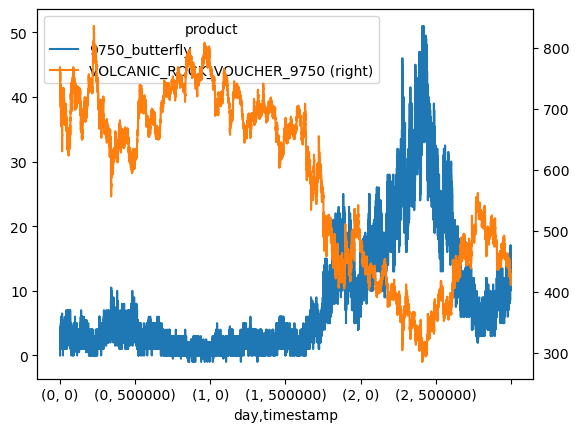

In [ ]:
payoff_df[[f"{9750}_butterfly", "VOLCANIC_ROCK_VOUCHER_9750"]].plot(
    secondary_y="VOLCANIC_ROCK_VOUCHER_9750"
)

In [57]:
for s in strike:
    print(s)
    print(
        (
            payoff_df[f"VOLCANIC_ROCK_VOUCHER_{s}"] - payoff_df[f"{s}_payoff"]
        ).value_counts()
    )

9500
 0.5    15300
 0.0    12177
 1.0     2082
-0.5      392
 1.5       39
-1.0        9
 2.0        1
Name: count, dtype: int64
9750
 0.5    9076
 1.0    8139
 1.5    3454
 0.0    2218
 2.0    2093
 2.5    1458
 3.0    1087
 3.5     716
 4.0     507
 4.5     347
 5.0     307
 5.5     219
 6.0     159
 6.5      78
-0.5      52
 7.0      51
 7.5      25
 8.0      11
 8.5       3
Name: count, dtype: int64
10000
2.5     2536
3.0     2340
2.0     2156
3.5     1911
4.0     1534
        ... 
61.5       3
62.0       3
61.0       2
63.5       1
60.5       1
Name: count, Length: 125, dtype: int64
10250
22.5    638
25.5    633
26.5    605
20.5    582
19.5    581
       ... 
9.5      17
79.0     15
81.5      5
81.0      3
9.0       2
Name: count, Length: 146, dtype: int64
10500
2.5     1686
4.5     1621
6.5     1603
3.5     1471
5.5     1416
        ... 
35.0       1
22.0       1
20.0       1
24.0       1
21.0       1
Name: count, Length: 188, dtype: int64


In [58]:
payoff_df[payoff_df[f"{9500}_{9750}_bcp_arb"] == 1][f"{9500}_{9750}_bcp"].value_counts()

9500_9750_bcp
250.5    11
Name: count, dtype: int64

In [59]:
for i in range(len(strike)):
    if strike[i] not in [9500, 10500]:
        print(strike[i])
        print(payoff_df[f"{strike[i]}_butterfly_arb"].sum())

9750
28
10000
0
10250
0


In [60]:
payoff_df[payoff_df[f"{9500}_call_arb"] == 1][
    [f"{9500}_payoff", "VOLCANIC_ROCK_VOUCHER_9500"]
]

product        9500_payoff  VOLCANIC_ROCK_VOUCHER_9500
day timestamp                                         
0   4200             966.5                       966.0
    12200            928.5                       928.0
    15800            957.5                       957.0
    41400            935.5                       935.0
    42000            929.0                       928.5
...                    ...                         ...
2   984400           701.0                       700.5
    985300           701.0                       700.5
    992700           677.5                       677.0
    996500           677.0                       676.5
    997700           671.0                       670.5

[401 rows x 2 columns]

In [61]:
payoff_df.columns

Index(['VOLCANIC_ROCK', 'VOLCANIC_ROCK_VOUCHER_9500',
       'VOLCANIC_ROCK_VOUCHER_9750', 'VOLCANIC_ROCK_VOUCHER_10000',
       'VOLCANIC_ROCK_VOUCHER_10250', 'VOLCANIC_ROCK_VOUCHER_10500',
       '9500_payoff', '9500_call_arb', '9750_payoff', '9750_call_arb',
       '10000_payoff', '10000_call_arb', '10250_payoff', '10250_call_arb',
       '10500_payoff', '10500_call_arb', '9750_butterfly',
       '9750_butterfly_arb', '10000_butterfly', '10000_butterfly_arb',
       '10250_butterfly', '10250_butterfly_arb', '9500_9750_bcp',
       '9500_9750_bcp_arb', '9500_10000_bcp', '9500_10000_bcp_arb',
       '9500_10250_bcp', '9500_10250_bcp_arb', '9500_10500_bcp',
       '9500_10500_bcp_arb', '9750_10000_bcp', '9750_10000_bcp_arb',
       '9750_10250_bcp', '9750_10250_bcp_arb', '9750_10500_bcp',
       '9750_10500_bcp_arb', '10000_10250_bcp', '10000_10250_bcp_arb',
       '10000_10500_bcp', '10000_10500_bcp_arb', '10250_10500_bcp',
       '10250_10500_bcp_arb'],
      dtype='object', name='pr

In [62]:
payoff_df["10250_butterfly"].value_counts().head(10)

10250_butterfly
83.0     619
84.0     556
74.0     555
76.0     552
112.0    544
85.0     542
111.0    537
113.0    536
77.0     535
122.0    517
Name: count, dtype: int64

In [63]:
payoff_df["10250_butterfly"].value_counts().head(10)

10250_butterfly
83.0     619
84.0     556
74.0     555
76.0     552
112.0    544
85.0     542
111.0    537
113.0    536
77.0     535
122.0    517
Name: count, dtype: int64

<Axes: xlabel='day,timestamp'>

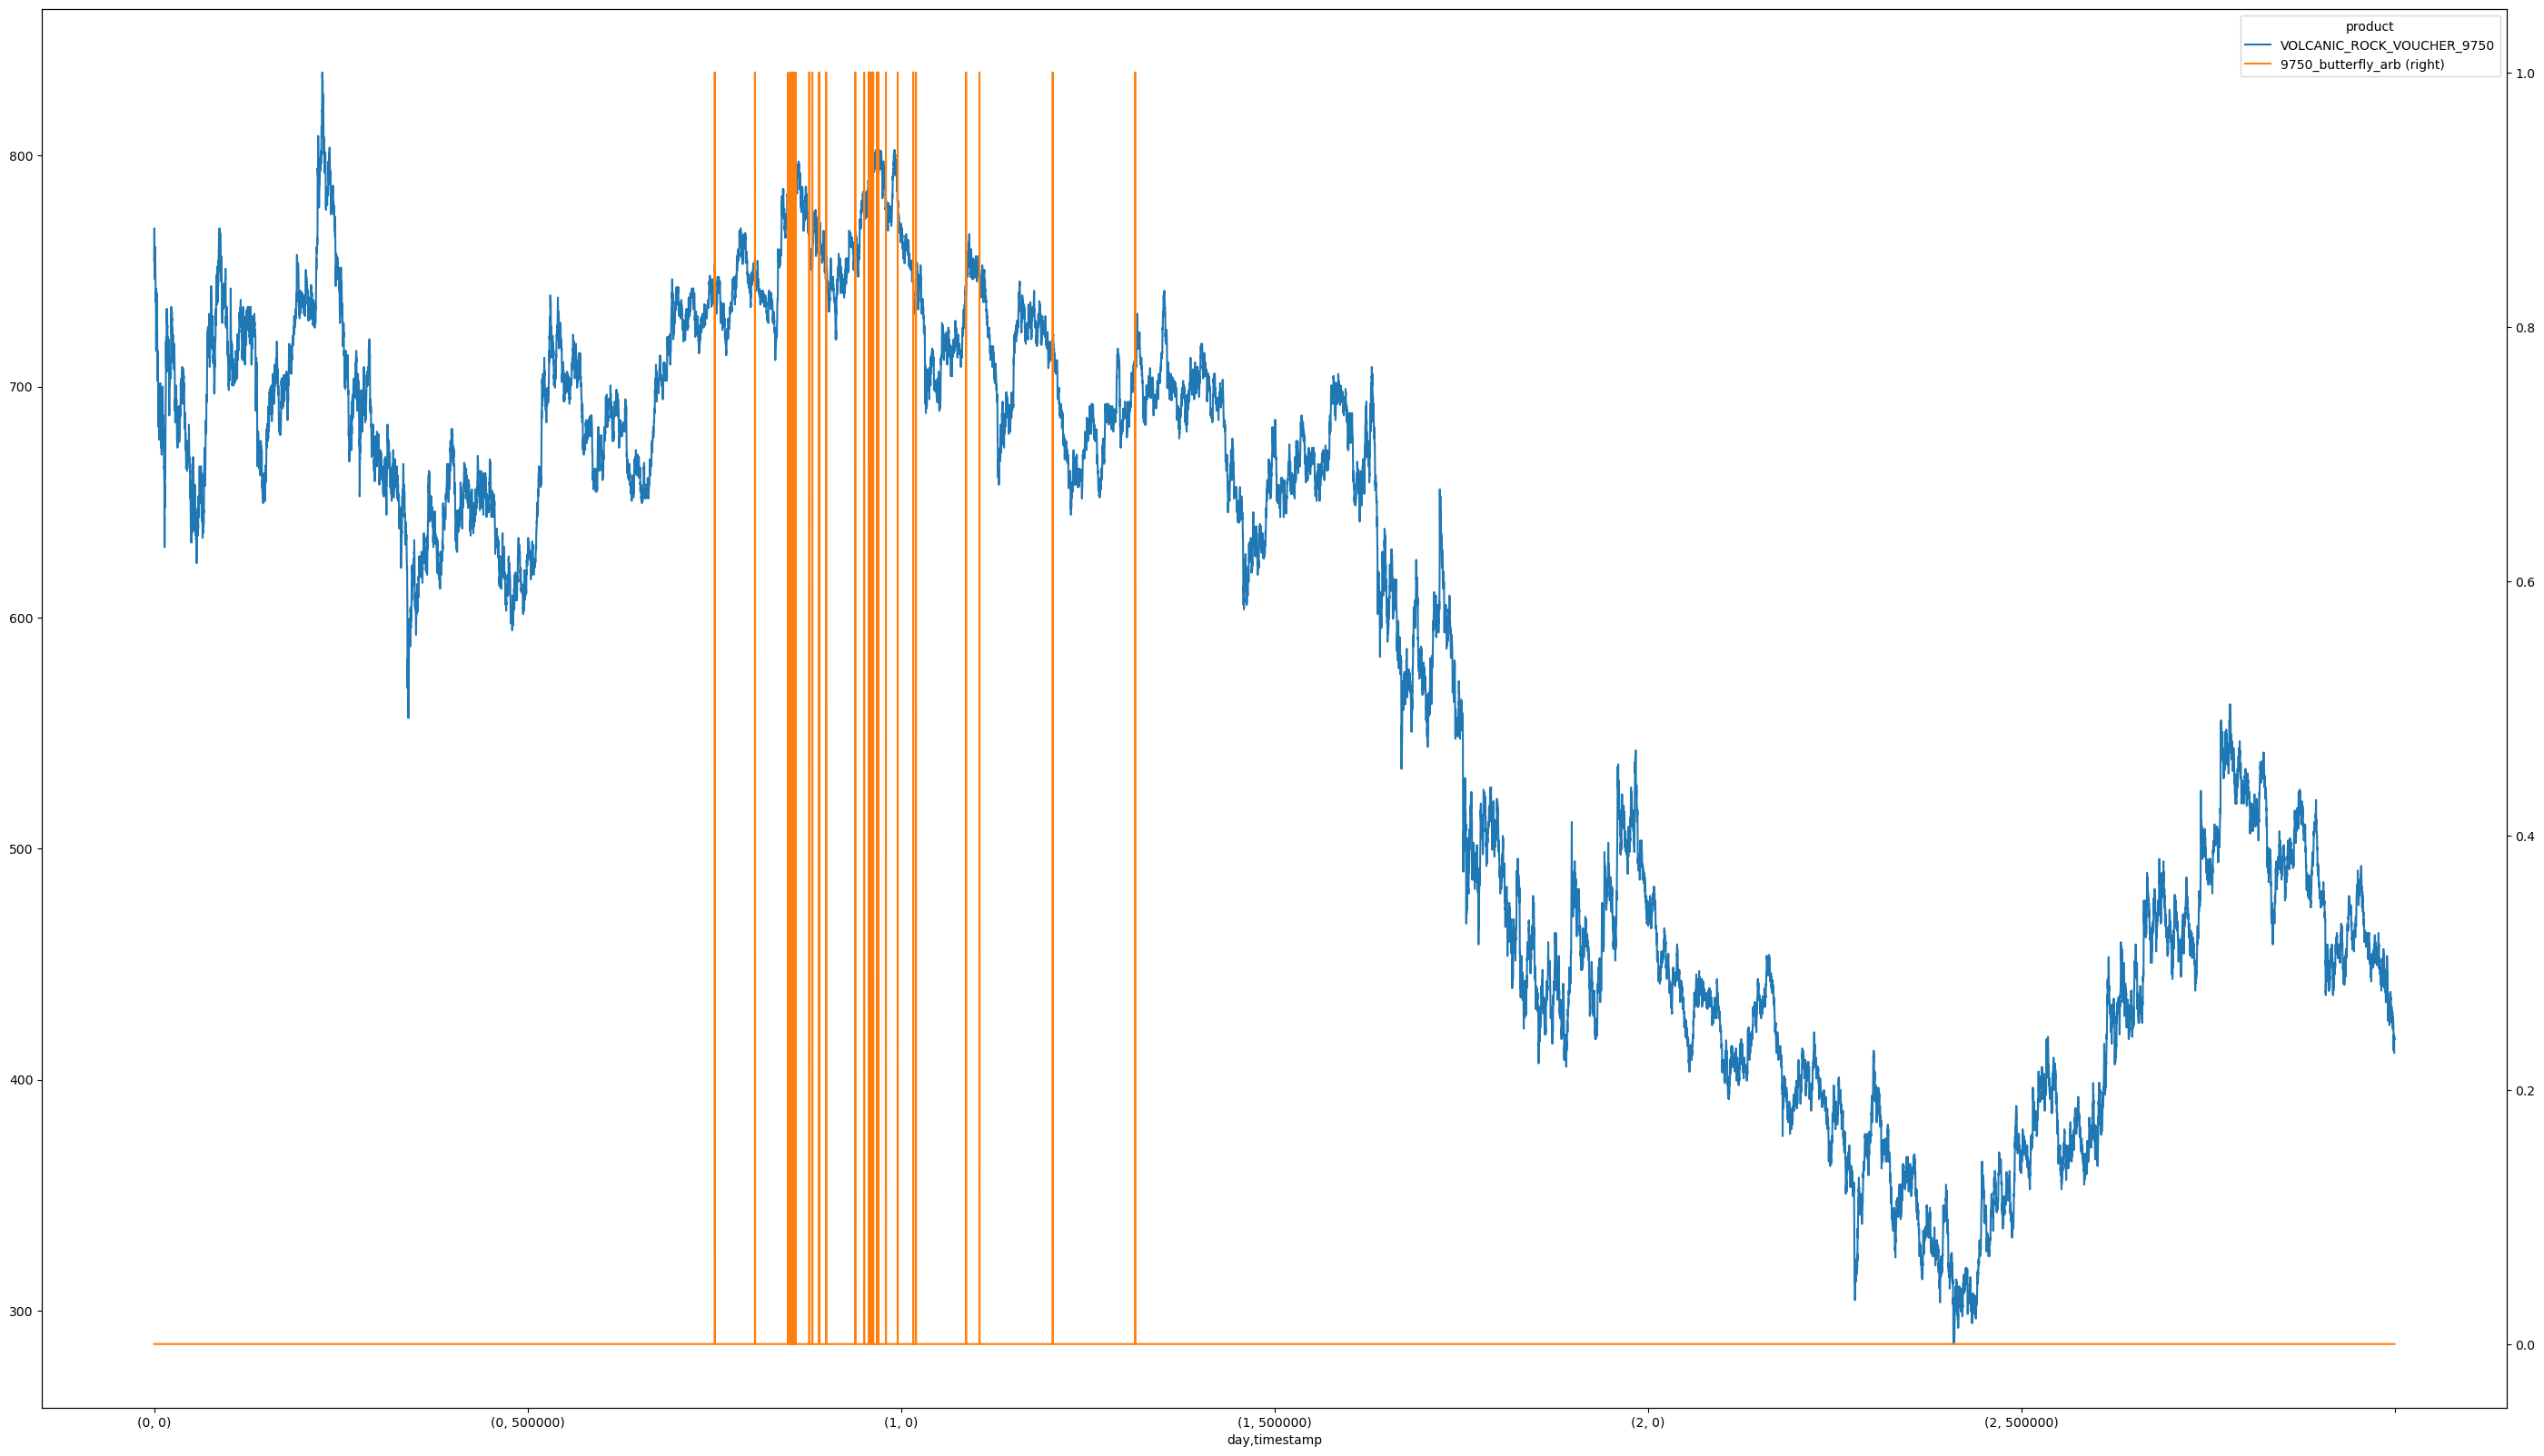

In [64]:
payoff_df[
    [
        # "VOLCANIC_ROCK",
        # "VOLCANIC_ROCK_VOUCHER_9500",
        "VOLCANIC_ROCK_VOUCHER_9750",
        # "VOLCANIC_ROCK_VOUCHER_10000",
        # "VOLCANIC_ROCK_VOUCHER_10250",
        # "VOLCANIC_ROCK_VOUCHER_10500",
        # "9500_payoff",
        # "9500_call_arb",
        # "9750_payoff",
        # "9750_call_arb",
        # "10000_payoff",
        # "10000_call_arb",
        # "10250_payoff",
        # "10250_call_arb",
        # "10500_payoff",
        # "10500_call_arb",
        # "9750_butterfly",
        "9750_butterfly_arb",
        # "10000_butterfly",
        # "10000_butterfly_arb",
        # "10250_butterfly",
        # "10250_butterfly_arb",
    ]
].plot(figsize=(35, 20), secondary_y="9750_butterfly_arb")

In [65]:
vol_df["rock_vol"] = payoff_df["VOLCANIC_ROCK"].pct_change().rolling(
    window=1000
).std() * np.sqrt(252e3)


<Axes: xlabel='day,timestamp'>

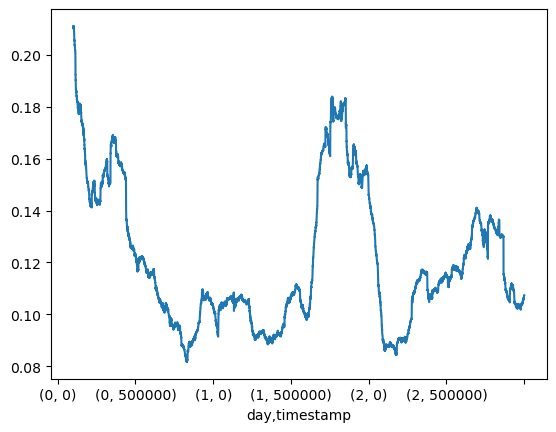

In [66]:
vol_df["rock_vol"].plot()

In [67]:
import math


def phi(x):
    return (1.0 + math.erf(x / np.sqrt(2.0))) / 2.0


def black_scholes_call(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * phi(d1) - K * np.exp(-r * T) * phi(d2)


def call_delta(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    return phi(d1)


def vega(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * np.exp(-0.5 * d1**2) / np.sqrt(2 * np.pi) * np.sqrt(T)


def solve_iv(call_price, S, K, r, T, initial_guess=0.2, max_iter=1000, tol=1e-6):
    solution = initial_guess
    for _ in range(max_iter):
        f_val = black_scholes_call(S, K, r, solution, T) - call_price
        f_prime_val = vega(S, K, r, solution, T)
        if abs(f_prime_val) < tol:
            break
        solution = solution - f_val / f_prime_val
        if abs(f_val) < tol:
            break
    return solution


In [68]:
(np.arange(len(vol_df)) * 100)

array([      0,     100,     200, ..., 2999700, 2999800, 2999900])

In [125]:
for i in strike:
    iv = []
    delta = []
    call_price = vol_df[f"VOLCANIC_ROCK_VOUCHER_{i}"].values
    s = vol_df["VOLCANIC_ROCK"].values
    r = (0,)
    T = (8e6 - (np.arange(len(vol_df)) * 100)) / 252e6
    for j in range(len(vol_df)):
        iv.append(solve_iv(call_price=call_price[j], S=s[j], K=i, r=0, T=T[j]))
        delta.append(call_delta(S=s[j], K=i, r=0, sigma=iv[-1], T=T[j]))
    vol_df[f"{i}_delta"] = delta
    vol_df[f"{i}_iv"] = iv
    vol_df[f"{i}_iv"] = np.where(
        vol_df[f"{i}_iv"] < 0,
        0.2,
        np.where(vol_df[f"{i}_iv"] > 1, 0.2, vol_df[f"{i}_iv"]),
    )

<Axes: xlabel='day,timestamp'>

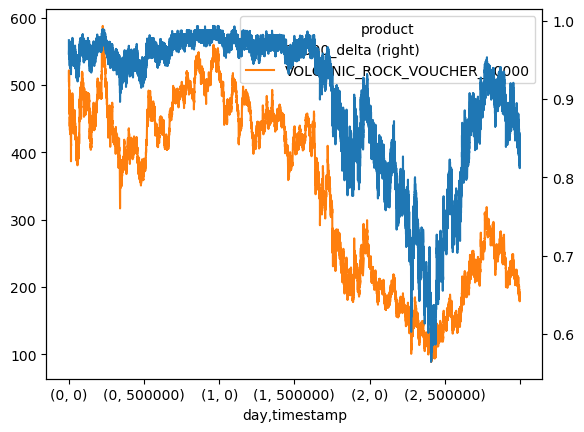

In [138]:
vol_df[['10000_delta', 'VOLCANIC_ROCK_VOUCHER_10000']].plot(secondary_y='10000_delta')

In [70]:
vol_df["time_to_expiry"] = (8e6 - (np.arange(len(vol_df)) * 100)) / 252e6
for i in strike:
    vol_df[f"mt_{i}"] = (
        np.log(i / vol_df[f"VOLCANIC_ROCK_VOUCHER_{i}"]) / vol_df["time_to_expiry"]
    )

In [71]:
vol_df.columns

Index(['VOLCANIC_ROCK', 'VOLCANIC_ROCK_VOUCHER_9500',
       'VOLCANIC_ROCK_VOUCHER_9750', 'VOLCANIC_ROCK_VOUCHER_10000',
       'VOLCANIC_ROCK_VOUCHER_10250', 'VOLCANIC_ROCK_VOUCHER_10500',
       'rock_vol', '9500_iv', '9750_iv', '10000_iv', '10250_iv', '10500_iv',
       'time_to_expiry', 'mt_9500', 'mt_9750', 'mt_10000', 'mt_10250',
       'mt_10500'],
      dtype='object', name='product')

In [ ]:
px.scatter(vol_df, x="mt_9500", y="9500_iv")

In [ ]:
for i in strike:
    print(i)
    print(np.polyfit(x=vol_df[f"mt_{i}"], y=vol_df[f"{i}_iv"], deg=2)[-1])

9500
0.23897464401182528
9750
0.19740891938069918
10000
0.18616207599728063
10250
0.15964140486902206
10500
0.13265885412932843


In [ ]:
computed_iv = {
    "9500": 0.23897464401182528,
    "9750": 0.19740891938069918,
    "10000": 0.18616207599728063,
    "10250": 0.15964140486902206,
    "10500": 0.13265885412932843,
}

In [ ]:
for i in strike:
    theo_price = []
    s = vol_df["VOLCANIC_ROCK"].values
    r = (0,)
    T = (8e6 - (np.arange(len(vol_df)) * 100)) / 252e6
    for j in range(len(vol_df)):
        theo_price.append(
            black_scholes_call(S=s[j], K=i, r=0, T=T[j], sigma=computed_iv[str(i)])
        )
    vol_df[f"{i}_theo_price"] = theo_price
    vol_df[f"{i}_theo_price_diff"] = vol_df[f"{i}_theo_price"].diff()
    vol_df[f"VOLCANIC_ROCK_VOUCHER_{i}_diff"] = vol_df[
        f"VOLCANIC_ROCK_VOUCHER_{i}"
    ].diff()
    vol_df[f"{i}_theo_price_diff"] = (
        vol_df[f"{i}_theo_price_diff"] - vol_df[f"VOLCANIC_ROCK_VOUCHER_{i}_diff"]
    )

<Axes: xlabel='day,timestamp'>

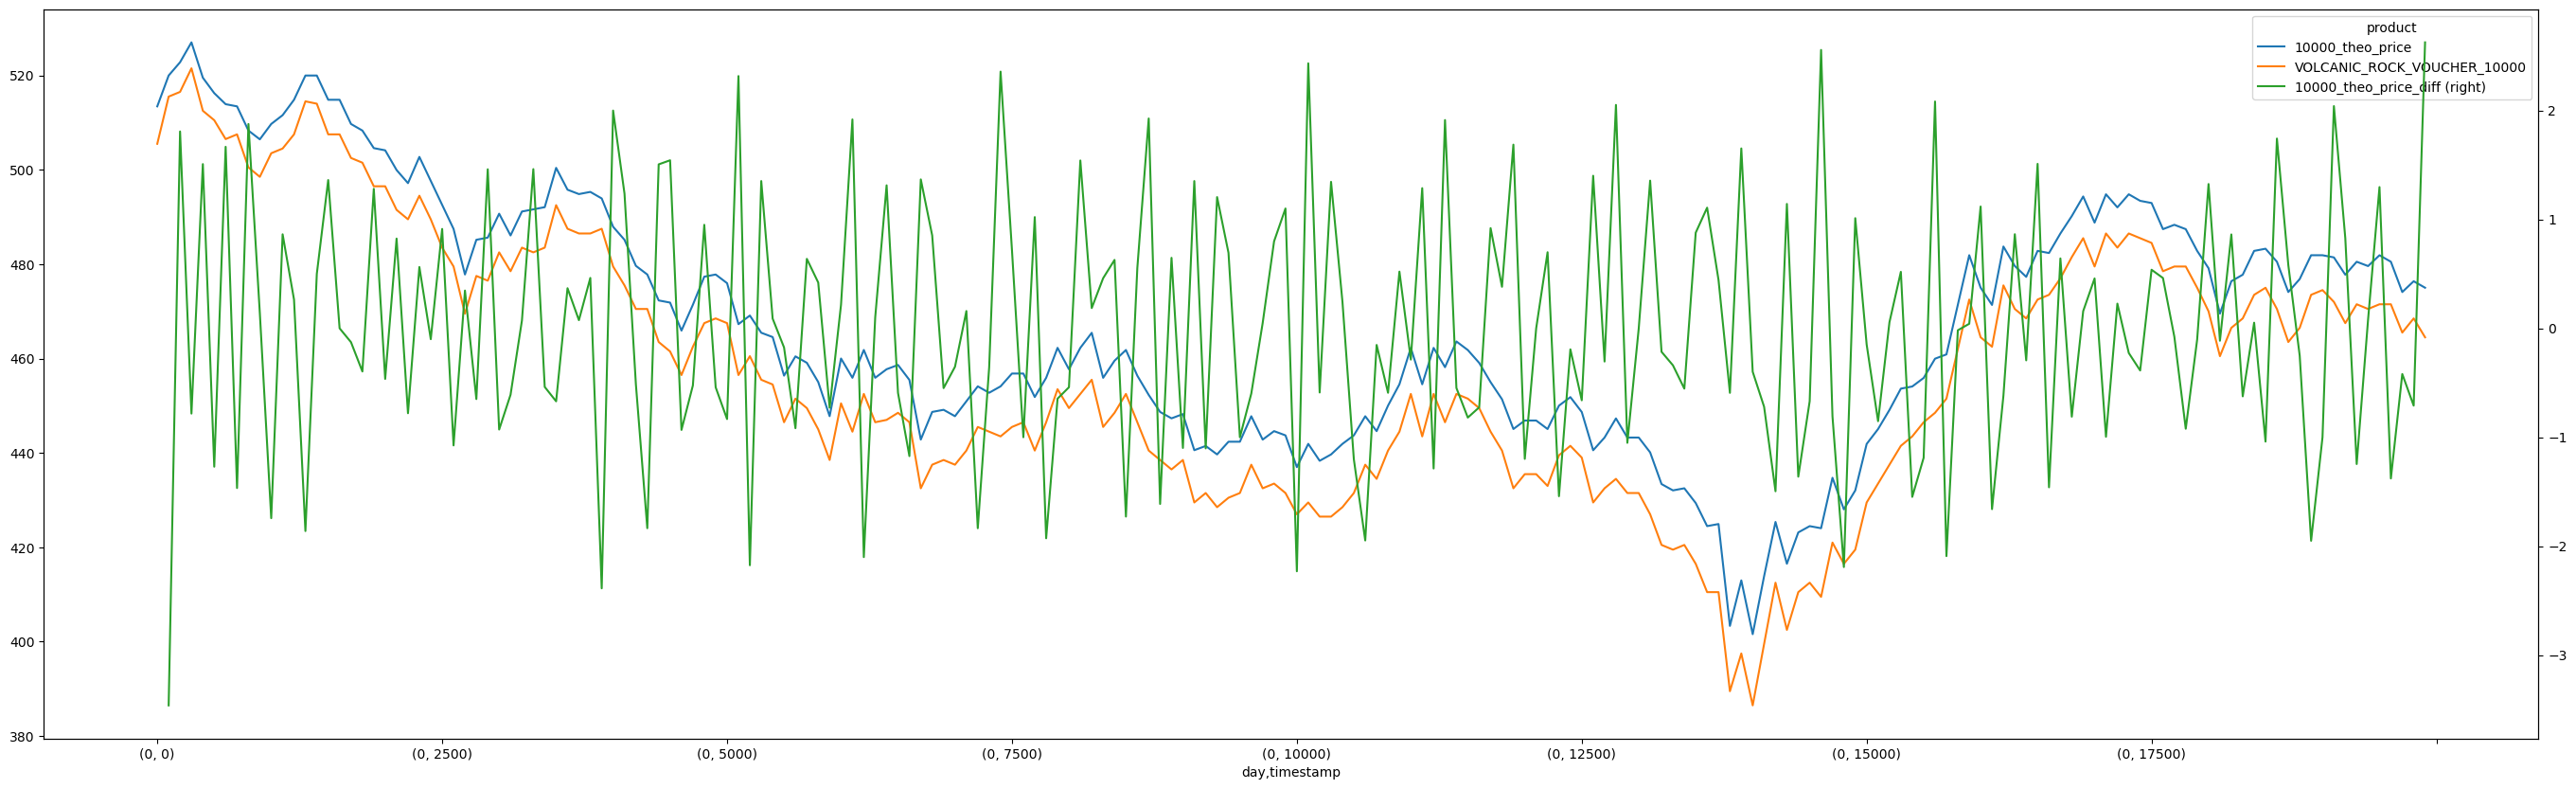

In [ ]:
vol_df[
    [f"10000_theo_price", "VOLCANIC_ROCK_VOUCHER_10000", f"{10000}_theo_price_diff"]
].iloc[:200].plot(figsize=(34, 10), secondary_y=f"{10000}_theo_price_diff")

In [ ]:
vol_df[
    [
        "9500_iv",
        "9750_iv",
        "10000_iv",
        "10250_iv",
        "10500_iv",
    ]
]

product         9500_iv   9750_iv  10000_iv  10250_iv  10500_iv
day timestamp                                                  
0   0          0.213879  0.186998  0.141239  0.135554  0.131280
    100        0.215142  0.188439  0.164308  0.135674  0.130467
    200        0.215683  0.189057  0.151878  0.136698  0.131045
    300        0.216495  0.180272  0.156603  0.134665  0.130532
    400        0.215056  0.178696  0.147099  0.136660  0.130819
...                 ...       ...       ...       ...       ...
2   999500     0.085731  0.124987  0.119727  0.121998  0.133646
    999600     0.191224  0.144898  0.127606  0.122627  0.133978
    999700     0.191226  0.144899  0.122108  0.122628  0.133979
    999800     0.085684  0.136725  0.129191  0.122315  0.133815
    999900     0.085586  0.136451  0.117602  0.122944  0.134148

[30000 rows x 5 columns]

<Axes: xlabel='day,timestamp'>

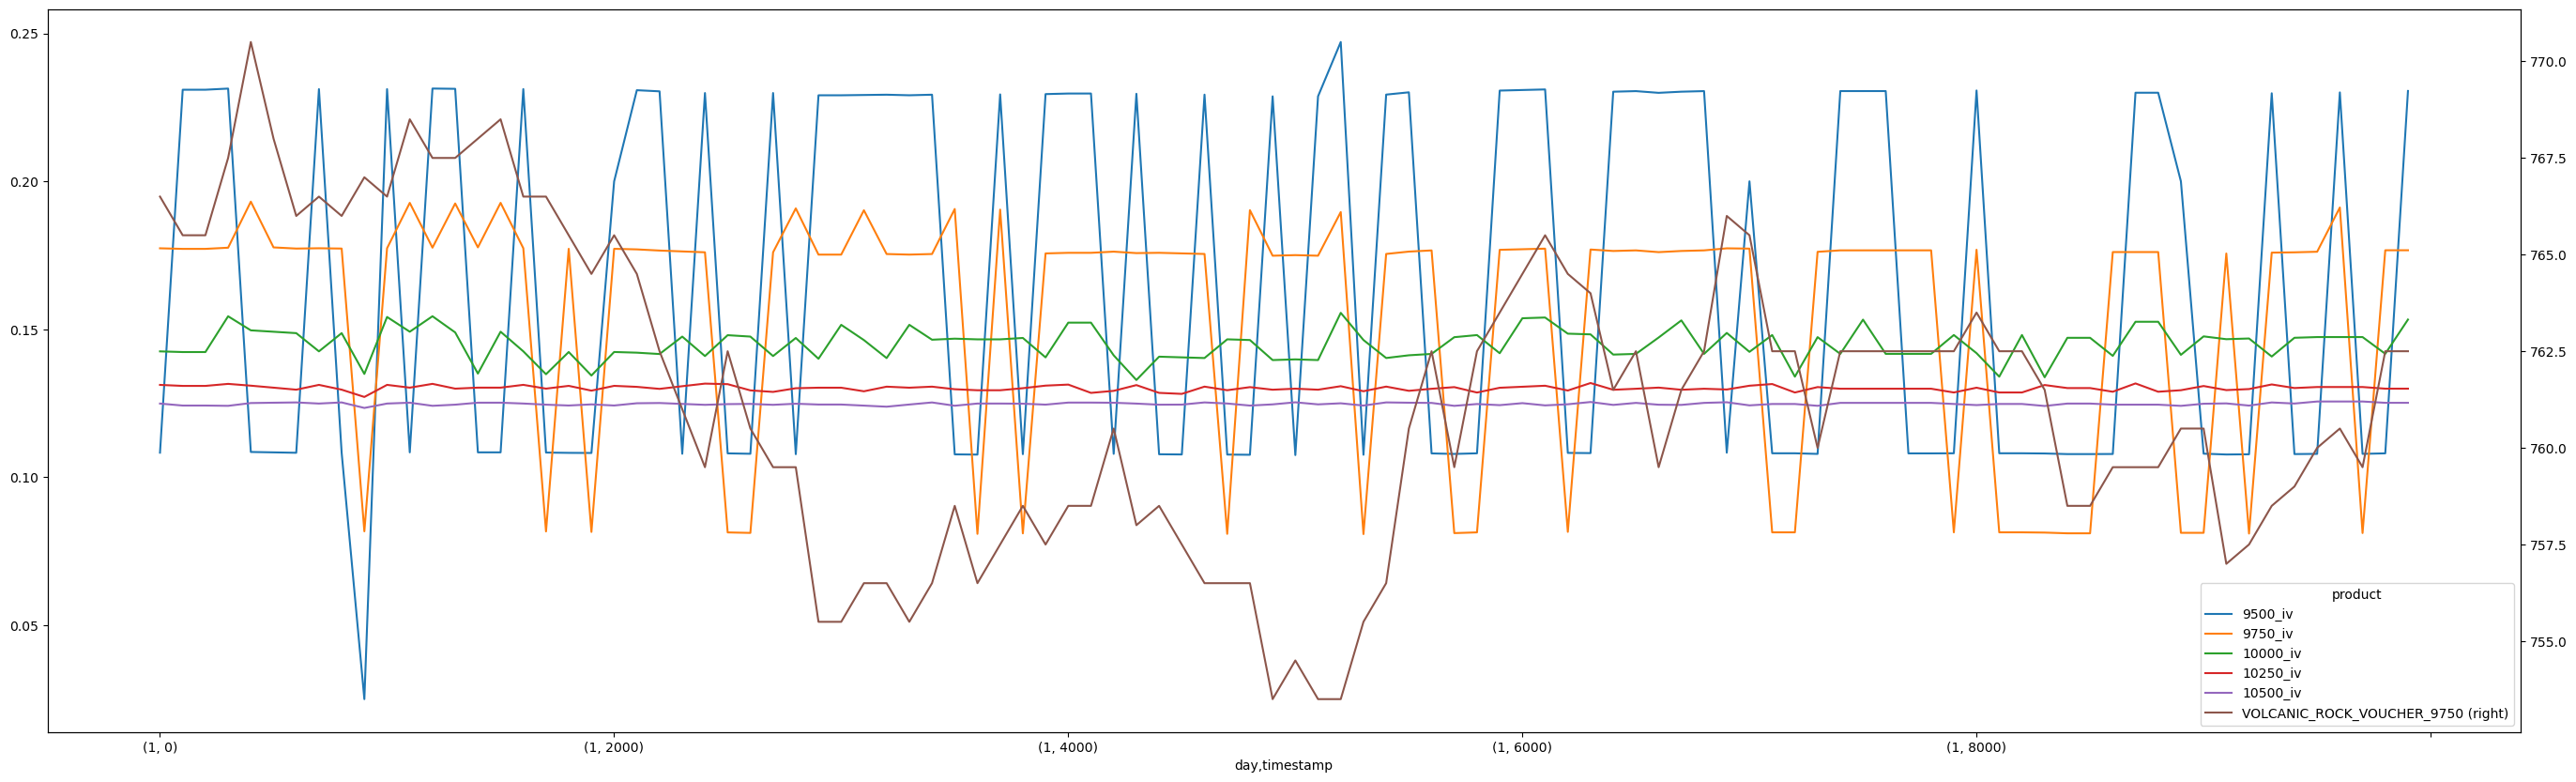

In [ ]:
vol_df[
    [
        "9500_iv",
        "9750_iv",
        "10000_iv",
        "10250_iv",
        "10500_iv",
        "VOLCANIC_ROCK_VOUCHER_9750",
    ]
].iloc[10000:10100].plot(figsize=(34, 10), secondary_y=["VOLCANIC_ROCK_VOUCHER_9750"])

<Axes: xlabel='day,timestamp'>

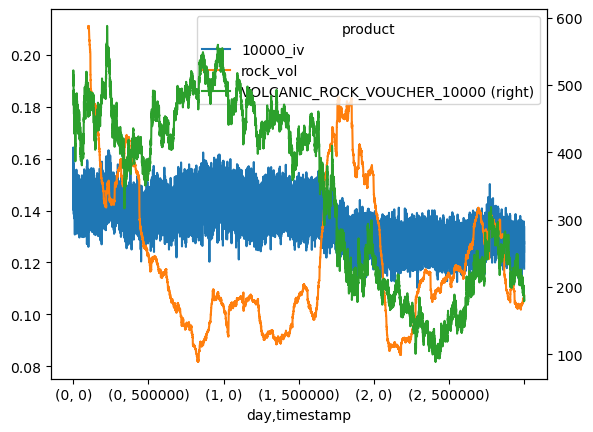

In [79]:
vol_df[["10000_iv", "rock_vol", "VOLCANIC_ROCK_VOUCHER_10000"]].plot(
    secondary_y="VOLCANIC_ROCK_VOUCHER_10000"
)

In [ ]:
vol_df["9500_z"] = (
    vol_df["9500_iv"] - vol_df["9500_iv"].rolling(window=1000).mean()
) / vol_df["9500_iv"].rolling(window=1000).std()

vol_df["9500_z"].describe()

count    29001.000000
mean        -0.010545
std          1.003429
min         -3.612042
25%         -1.010169
50%          0.533914
75%          0.883017
max          1.693029
Name: 9500_z, dtype: float64

In [ ]:
for i in strike:
    print(i)
    vol_df[f"{i}_z"] = (
        vol_df[f"{i}_iv"] - vol_df[f"{i}_iv"].rolling(window=1000).mean()
    ) / vol_df[f"{i}_iv"].rolling(window=1000).std()

    print(np.percentile(vol_df[f"{i}_z"].dropna(), 90))

9500
1.059128940308789
9750
0.8600954832723592
10000
1.2651093313307173
10250
1.3923953674290663
10500
1.6777865342072642


count    29996.000000
mean        -0.000886
std          0.896299
min         -1.788854
25%         -0.723759
50%          0.008762
75%          0.724681
max          1.788854
Name: 10000_z, dtype: float64


<Axes: xlabel='day,timestamp'>

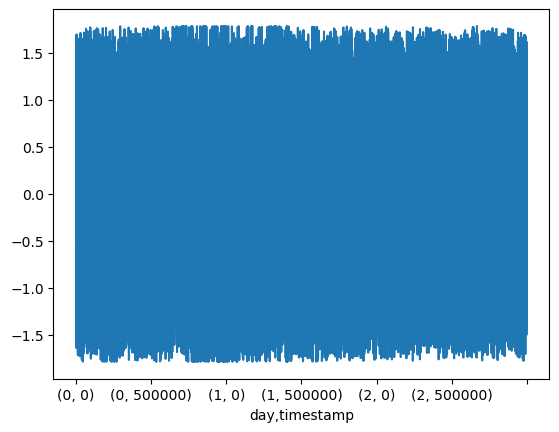

In [121]:
vol_df["10000_z"] = (
    vol_df["10000_iv"] - vol_df["10000_iv"].rolling(window=5).mean()
) / vol_df["10000_iv"].rolling(window=5).std()

print(vol_df["10000_z"].describe())
vol_df["10000_z"].plot()

In [105]:
vol_df.columns

Index(['VOLCANIC_ROCK', 'VOLCANIC_ROCK_VOUCHER_9500',
       'VOLCANIC_ROCK_VOUCHER_9750', 'VOLCANIC_ROCK_VOUCHER_10000',
       'VOLCANIC_ROCK_VOUCHER_10250', 'VOLCANIC_ROCK_VOUCHER_10500',
       'rock_vol', '9500_iv', '9750_iv', '10000_iv', '10250_iv', '10500_iv',
       'time_to_expiry', 'mt_9500', 'mt_9750', 'mt_10000', 'mt_10250',
       'mt_10500', '9500_theo_price', '9500_theo_price_diff',
       'VOLCANIC_ROCK_VOUCHER_9500_diff', '9750_theo_price',
       '9750_theo_price_diff', 'VOLCANIC_ROCK_VOUCHER_9750_diff',
       '10000_theo_price', '10000_theo_price_diff',
       'VOLCANIC_ROCK_VOUCHER_10000_diff', '10250_theo_price',
       '10250_theo_price_diff', 'VOLCANIC_ROCK_VOUCHER_10250_diff',
       '10500_theo_price', '10500_theo_price_diff',
       'VOLCANIC_ROCK_VOUCHER_10500_diff', '9500_z', '9750_z', '10000_z',
       '10250_z', '10500_z'],
      dtype='object', name='product')